In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from copy import deepcopy

Using TensorFlow backend.


In [2]:
model = InceptionV3(weights='imagenet')

In [3]:
model_transform =  Model(model.input, model.layers[-2].output)

In [ ]:
model_transform.summary()

In [4]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [5]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_transform.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [6]:
def prepare_training_data(lda_result_file , directory_name,train_x_begin ):
    f = open(lda_result_file,"rb")
    dict_lda = load(f)
    train_x = train_x_begin
    train_y = []
    #print(dict_lda)
    for index,key in enumerate(dict_lda.keys()):
        #print("key",key,"index",index)
        image_path = directory_name + "/" + "COCO_val2014_"+get_path(key)+".jpg"

        image_vector = encode(image_path)
        train_x.insert(index, list(image_vector))
        train_y.append(list(dict_lda[key]))
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    
    return train_x,train_y

In [7]:
def get_path(key):
    len1 = len(str(key))
    str2 = "0"*(12-len1) + str(key)
    return str2

In [ ]:
#train_x = load(open("train_x","rb"))
train_x , train_y = prepare_training_data("ProjectFile_val2017/leecopper_30_top/ldaResult","val2017",np.ndarray.tolist(train_x))

In [ ]:
train_y.shape

In [ ]:
train_x = load(open("train_x","rb"))
#train_y = load(open("train_y","rb"))

In [ ]:
print("YESSSSSSSSSSS")

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=2048))
model.add(Activation('relu'))

# model.add(Dense(256, input_dim=512))
# model.add(Activation('relu'))

model.add(Dense(128, input_dim=256))
model.add(Activation('relu'))

model.add(Dense(30, input_dim=128))
model.add(Activation('softmax'))

model.summary()

adam_opt = optimizers.adam(lr=0.001)
model.compile(optimizer=adam_opt , loss="categorical_crossentropy",metrics=['accuracy'])

model.fit(train_x_appended,train_y,epochs=500,verbose=True)

In [ ]:
# with open("train_x","wb") as f:
#     dump(train_x,f)

# with open("train_y","wb") as f:
#     dump(train_y,f)

In [ ]:
# with open("models/model_30_topics_30_words_acc_91_2:03am_val_2017_70_passes","wb") as f:
#     dump(model,f)

In [10]:
def predict_test_image(image_path):
    image_vector = encode(image_path)
    image_vector_1 = np.array([image_vector])
    print(image_vector_1.shape)
    probas = model_loaded.predict(image_vector_1)
    return probas

In [11]:
def predict_words_probablity(image_path , dictionary_file_name , topic_word_file,  num_of_topics ):
    f = open(topic_word_file , 'rb')
    topic_word_prob = load(f)
    all_unique_words_in_topics = []
    final_probablity = {}
    
    probality_topic_image = list(predict_test_image(image_path))
    
    for topic_num in topic_word_prob.keys():
        for word in topic_word_prob[topic_num].keys():
            if word not in all_unique_words_in_topics:
                all_unique_words_in_topics.append(word)
                
    for word in all_unique_words_in_topics:
        
        for topic in topic_word_prob.keys():
            
            #print(topic,word)
            if word not in final_probablity:
                final_probablity[word] = 0
            
            if word in topic_word_prob[topic]:
                final_probablity[word] += topic_word_prob[topic][word]*probality_topic_image[0][topic]
    
    sorted_probs_word_text = [(k, final_probablity[k]) for k in sorted(final_probablity, key=final_probablity.get, reverse=True)]
    return sorted_probs_word_text

In [ ]:
#probabs = predict_words_probablity("83085.jpg",'Dict','ProjectFile_val2017/Pro_top=30_pass=70_top=30words:8:50pm/topic_word_prob',10)

In [12]:
model_loaded = load(open("models/model_30_topics_30_words_acc_92_1:15am_val_2017_10_passes","rb"))


In [22]:
def test_images(dirname,num_of_topics):
    for filenames in os.listdir(dirname):
        
        plt.imshow(np.array(Image.open(dirname+"/"+filenames)))
        plt.show()
        probabs = predict_words_probablity(dirname+"/"+filenames,'Dict','ProjectFile_val2017/Pro_top=30_pass=10_top=30words:8:45pm/topic_word_prob',num_of_topics)
        for index,i in enumerate(probabs[:250]):
            print('Rank:',index + 1,i[0].upper())

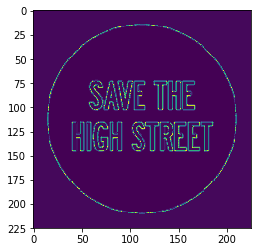

(1, 2048)
Rank: 1 HOLD
Rank: 2 WOMAN
Rank: 3 SKATEBOARD
Rank: 4 UMBRELLA
Rank: 5 PERSON
Rank: 6 YOUNG
Rank: 7 TRICK
Rank: 8 CHILD
Rank: 9 HAND
Rank: 10 SKATE
Rank: 11 STAND
Rank: 12 BOARD
Rank: 13 PEOPLE
Rank: 14 WEAR
Rank: 15 PIZZA
Rank: 16 SKATEBOARDER
Rank: 17 RAMP
Rank: 18 JUMP
Rank: 19 WALK
Rank: 20 GIRAFFE
Rank: 21 LITTLE
Rank: 22 GROUP
Rank: 23 SHIRT
Rank: 24 BLACK
Rank: 25 SMILE
Rank: 26 BABY
Rank: 27 LOOK
Rank: 28 SMALL
Rank: 29 PERFORM
Rank: 30 PICTURE
Rank: 31 ZEBRA
Rank: 32 LADY
Rank: 33 GIRAFFES
Rank: 34 TABLE
Rank: 35 PLATE
Rank: 36 HELMET
Rank: 37 ZEBRAS
Rank: 38 RAIN
Rank: 39 STREET
Rank: 40 TREE
Rank: 41 SLICE
Rank: 42 FOOD
Rank: 43 LARGE
Rank: 44 COUPLE
Rank: 45 WHITE
Rank: 46 CAKE
Rank: 47 NEAR
Rank: 48 FIELD
Rank: 49 WOMEN
Rank: 50 BEACH
Rank: 51 PLAY
Rank: 52 SANDWICH
Rank: 53 CHEESE
Rank: 54 GRASS
Rank: 55 SOCCER
Rank: 56 WATCH
Rank: 57 DIFFERENT
Rank: 58 AREA
Rank: 59 DIRT
Rank: 60 CROWD
Rank: 61 CHILDREN
Rank: 62 ANIMALS
Rank: 63 ENCLOSURE
Rank: 64 DISPLAY
Rank:

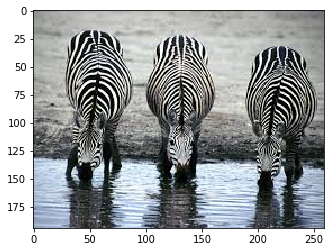

(1, 2048)
Rank: 1 STAND
Rank: 2 FIELD
Rank: 3 GRASS
Rank: 4 PIZZA
Rank: 5 SHEEP
Rank: 6 GIRAFFE
Rank: 7 FENCE
Rank: 8 TREE
Rank: 9 GRASSY
Rank: 10 WALK
Rank: 11 GRAZE
Rank: 12 ZEBRA
Rank: 13 GIRAFFES
Rank: 14 GREEN
Rank: 15 NEAR
Rank: 16 ZEBRAS
Rank: 17 HERD
Rank: 18 GROUP
Rank: 19 LARGE
Rank: 20 LOOK
Rank: 21 WOMAN
Rank: 22 AREA
Rank: 23 ELEPHANT
Rank: 24 BLACK
Rank: 25 ANIMALS
Rank: 26 SMALL
Rank: 27 WHITE
Rank: 28 TABLE
Rank: 29 WEAR
Rank: 30 ELEPHANTS
Rank: 31 TALL
Rank: 32 SLICE
Rank: 33 LUSH
Rank: 34 BROWN
Rank: 35 PASTURE
Rank: 36 DIRT
Rank: 37 OPEN
Rank: 38 PLATE
Rank: 39 BABY
Rank: 40 WIRE
Rank: 41 SUIT
Rank: 42 HOLD
Rank: 43 POSE
Rank: 44 ROCK
Rank: 45 YARD
Rank: 46 PERSON
Rank: 47 CHEESE
Rank: 48 HILL
Rank: 49 COVER
Rank: 50 SMILE
Rank: 51 ENCLOSURE
Rank: 52 GOATS
Rank: 53 SHIRT
Rank: 54 COUPLE
Rank: 55 SCISSOR
Rank: 56 PAIR
Rank: 57 BEAR
Rank: 58 TOPPINGS
Rank: 59 FOOD
Rank: 60 SUITCASE
Rank: 61 LEAVE
Rank: 62 PICNIC
Rank: 63 JACKET
Rank: 64 BASEBALL
Rank: 65 CARRY
Rank: 66

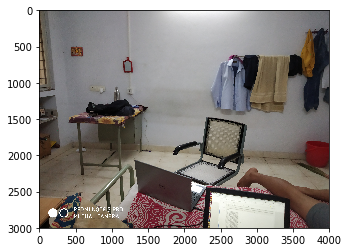

(1, 2048)
Rank: 1 LAPTOP
Rank: 2 DESK
Rank: 3 PEOPLE
Rank: 4 WINDOW
Rank: 5 PHONE
Rank: 6 LOOK
Rank: 7 TABLE
Rank: 8 CELL
Rank: 9 GROUP
Rank: 10 KEYBOARD
Rank: 11 STAND
Rank: 12 WALK
Rank: 13 WOMAN
Rank: 14 SCREEN
Rank: 15 MOUSE
Rank: 16 MONITOR
Rank: 17 WHITE
Rank: 18 OPEN
Rank: 19 BIRD
Rank: 20 GIRL
Rank: 21 PICTURE
Rank: 22 COMPUTERS
Rank: 23 HOLD
Rank: 24 OUTSIDE
Rank: 25 BLACK
Rank: 26 NEAR
Rank: 27 SMALL
Rank: 28 WORK
Rank: 29 PERSON
Rank: 30 KITCHEN
Rank: 31 WATCH
Rank: 32 BEACH
Rank: 33 OFFICE
Rank: 34 TAKE
Rank: 35 WOMEN
Rank: 36 YOUNG
Rank: 37 COUPLE
Rank: 38 CELLPHONE
Rank: 39 LAPTOPS
Rank: 40 DARK
Rank: 41 SILL
Rank: 42 ITEMS
Rank: 43 WATER
Rank: 44 PLAY
Rank: 45 BLUE
Rank: 46 DESKTOP
Rank: 47 LARGE
Rank: 48 WOODEN
Rank: 49 SOCCER
Rank: 50 LITTLE
Rank: 51 CHAIR
Rank: 52 STAR
Rank: 53 CROWD
Rank: 54 RAINBOW
Rank: 55 SMART
Rank: 56 SIGN
Rank: 57 CHILDREN
Rank: 58 DISPLAY
Rank: 59 BUILD
Rank: 60 BANANA
Rank: 61 NOTEBOOK
Rank: 62 PAST
Rank: 63 POWER
Rank: 64 POSE
Rank: 65 TREE


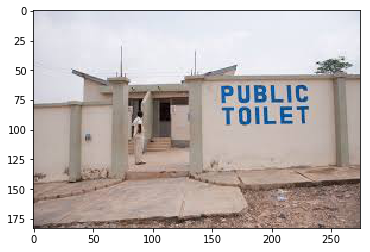

(1, 2048)
Rank: 1 STREET
Rank: 2 FIELD
Rank: 3 GRASS
Rank: 4 STAND
Rank: 5 BUILD
Rank: 6 CLOCK
Rank: 7 BEAR
Rank: 8 CITY
Rank: 9 LARGE
Rank: 10 LIGHT
Rank: 11 SHEEP
Rank: 12 FENCE
Rank: 13 SIGN
Rank: 14 GREEN
Rank: 15 TOWER
Rank: 16 GRASSY
Rank: 17 GRAZE
Rank: 18 WHITE
Rank: 19 TEDDY
Rank: 20 NEAR
Rank: 21 TRAFFIC
Rank: 22 TALL
Rank: 23 HERD
Rank: 24 ROAD
Rank: 25 CARS
Rank: 26 GLASS
Rank: 27 WALK
Rank: 28 STUFF
Rank: 29 GROUP
Rank: 30 TOILET
Rank: 31 BATHROOM
Rank: 32 PARK
Rank: 33 DRIVE
Rank: 34 WINE
Rank: 35 STOP
Rank: 36 ANIMALS
Rank: 37 TREE
Rank: 38 LOOK
Rank: 39 AREA
Rank: 40 POLE
Rank: 41 INTERSECTION
Rank: 42 NIGHT
Rank: 43 SMALL
Rank: 44 BLACK
Rank: 45 BUSY
Rank: 46 LUSH
Rank: 47 VIEW
Rank: 48 MOTORCYCLE
Rank: 49 BACKGROUND
Rank: 50 CORNER
Rank: 51 KITE
Rank: 52 OPEN
Rank: 53 BRICK
Rank: 54 PASTURE
Rank: 55 TRUCK
Rank: 56 BROWN
Rank: 57 BLUE
Rank: 58 CROSS
Rank: 59 PICTURE
Rank: 60 SIDEWALK
Rank: 61 SINK
Rank: 62 AIRPLANE
Rank: 63 WIRE
Rank: 64 HYDRANT
Rank: 65 PLANE
Rank: 66

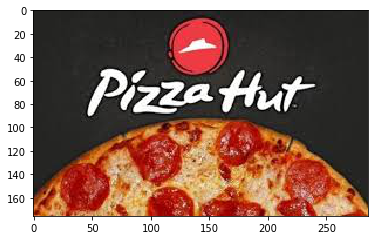

(1, 2048)
Rank: 1 PIZZA
Rank: 2 GIRAFFE
Rank: 3 STAND
Rank: 4 ZEBRA
Rank: 5 GIRAFFES
Rank: 6 BASEBALL
Rank: 7 ZEBRAS
Rank: 8 TABLE
Rank: 9 TREE
Rank: 10 FIELD
Rank: 11 SLICE
Rank: 12 LOOK
Rank: 13 LARGE
Rank: 14 NEAR
Rank: 15 PLAYER
Rank: 16 PLATE
Rank: 17 GAME
Rank: 18 GROUP
Rank: 19 SMALL
Rank: 20 BALL
Rank: 21 GRASS
Rank: 22 WHITE
Rank: 23 WALK
Rank: 24 COUPLE
Rank: 25 DIRT
Rank: 26 AREA
Rank: 27 DIFFERENT
Rank: 28 CHEESE
Rank: 29 SWING
Rank: 30 ANIMALS
Rank: 31 ENCLOSURE
Rank: 32 PLAYERS
Rank: 33 PLAY
Rank: 34 BATTER
Rank: 35 DISPLAY
Rank: 36 TALL
Rank: 37 TOPPINGS
Rank: 38 PIZZAS
Rank: 39 FOOD
Rank: 40 WALL
Rank: 41 LEAVE
Rank: 42 BEAR
Rank: 43 PICNIC
Rank: 44 WOODEN
Rank: 45 BASE
Rank: 46 PITCH
Rank: 47 PICTURE
Rank: 48 HANG
Rank: 49 UNIFORM
Rank: 50 WOMAN
Rank: 51 CATCHER
Rank: 52 HOLD
Rank: 53 READY
Rank: 54 WATCH
Rank: 55 POLAR
Rank: 56 TYPE
Rank: 57 HOME
Rank: 58 PEOPLE
Rank: 59 ROCK
Rank: 60 PEEL
Rank: 61 PLAT
Rank: 62 BLACK
Rank: 63 TEAM
Rank: 64 PITCHER
Rank: 65 THROW
Rank

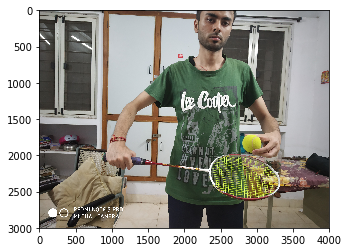

(1, 2048)
Rank: 1 PLATE
Rank: 2 HOLD
Rank: 3 WOMAN
Rank: 4 TENNIS
Rank: 5 SKATEBOARD
Rank: 6 FOOD
Rank: 7 CAKE
Rank: 8 UMBRELLA
Rank: 9 PERSON
Rank: 10 YOUNG
Rank: 11 TABLE
Rank: 12 SANDWICH
Rank: 13 WHITE
Rank: 14 HAND
Rank: 15 COURT
Rank: 16 TRICK
Rank: 17 BALL
Rank: 18 CHILD
Rank: 19 PIECE
Rank: 20 SKATE
Rank: 21 SLICE
Rank: 22 BROCCOLI
Rank: 23 WEAR
Rank: 24 RACKET
Rank: 25 PLAYER
Rank: 26 BOARD
Rank: 27 MEAT
Rank: 28 VEGETABLES
Rank: 29 PLAY
Rank: 30 STAND
Rank: 31 SKATEBOARDER
Rank: 32 FORK
Rank: 33 SERVE
Rank: 34 SMALL
Rank: 35 RAMP
Rank: 36 SHIRT
Rank: 37 PLAT
Rank: 38 SALAD
Rank: 39 BLACK
Rank: 40 PIZZA
Rank: 41 JUMP
Rank: 42 TRAY
Rank: 43 BREAD
Rank: 44 CHEESE
Rank: 45 LITTLE
Rank: 46 RACQUET
Rank: 47 DISH
Rank: 48 TRAIN
Rank: 49 SWING
Rank: 50 SMILE
Rank: 51 BABY
Rank: 52 BOWL
Rank: 53 CANDLE
Rank: 54 CLOSE
Rank: 55 LOOK
Rank: 56 HALF
Rank: 57 WALK
Rank: 58 SAUCE
Rank: 59 PERFORM
Rank: 60 CHOCOLATE
Rank: 61 COFFEE
Rank: 62 BIRTHDAY
Rank: 63 KNIFE
Rank: 64 LADY
Rank: 65 HELME

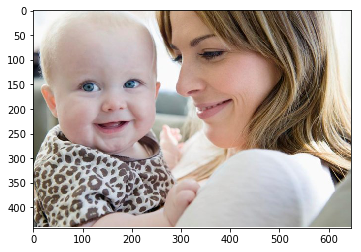

(1, 2048)
Rank: 1 HOLD
Rank: 2 WOMAN
Rank: 3 SKATEBOARD
Rank: 4 UMBRELLA
Rank: 5 PERSON
Rank: 6 YOUNG
Rank: 7 TRICK
Rank: 8 CHILD
Rank: 9 HAND
Rank: 10 SKATE
Rank: 11 BOARD
Rank: 12 WEAR
Rank: 13 SKATEBOARDER
Rank: 14 RAMP
Rank: 15 STAND
Rank: 16 PHONE
Rank: 17 JUMP
Rank: 18 LITTLE
Rank: 19 SHIRT
Rank: 20 BLACK
Rank: 21 SMILE
Rank: 22 BABY
Rank: 23 DESK
Rank: 24 PICTURE
Rank: 25 WALK
Rank: 26 PERFORM
Rank: 27 LADY
Rank: 28 LOOK
Rank: 29 CELL
Rank: 30 HELMET
Rank: 31 SMALL
Rank: 32 RAIN
Rank: 33 STREET
Rank: 34 BIKE
Rank: 35 BICYCLE
Rank: 36 MONITOR
Rank: 37 FRUIT
Rank: 38 BOOK
Rank: 39 TABLE
Rank: 40 KEYBOARD
Rank: 41 BANANAS
Rank: 42 APPLES
Rank: 43 OFFICE
Rank: 44 ORANGES
Rank: 45 COMPUTERS
Rank: 46 CELLPHONE
Rank: 47 TAKE
Rank: 48 ITEMS
Rank: 49 WHITE
Rank: 50 DESKTOP
Rank: 51 CHAIR
Rank: 52 READ
Rank: 53 BLUE
Rank: 54 SMART
Rank: 55 BANANA
Rank: 56 PLAN
Rank: 57 PILE
Rank: 58 LAPTOP
Rank: 59 GLASS
Rank: 60 NEAR
Rank: 61 LEAN
Rank: 62 APPLE
Rank: 63 SHOE
Rank: 64 BOWL
Rank: 65 CLUTT

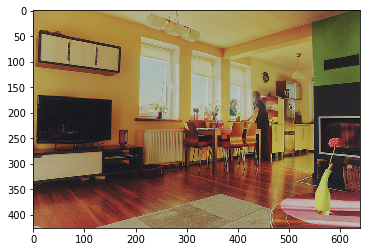

(1, 2048)
Rank: 1 ROOM
Rank: 2 LIVE
Rank: 3 CHAIR
Rank: 4 COUCH
Rank: 5 STAND
Rank: 6 TABLE
Rank: 7 WOMAN
Rank: 8 LARGE
Rank: 9 ELEPHANT
Rank: 10 WALK
Rank: 11 FURNITURE
Rank: 12 WEAR
Rank: 13 ELEPHANTS
Rank: 14 TELEVISION
Rank: 15 BEDROOM
Rank: 16 WINDOWS
Rank: 17 BLACK
Rank: 18 KITCHEN
Rank: 19 WHITE
Rank: 20 AREA
Rank: 21 BROWN
Rank: 22 LOOK
Rank: 23 HOUSE
Rank: 24 REMOTE
Rank: 25 FIREPLACE
Rank: 26 VIEW
Rank: 27 BABY
Rank: 28 FLOOR
Rank: 29 SOFA
Rank: 30 HOLD
Rank: 31 SUIT
Rank: 32 WINDOW
Rank: 33 FILL
Rank: 34 POSE
Rank: 35 WOODEN
Rank: 36 LIGHT
Rank: 37 ROCK
Rank: 38 TREE
Rank: 39 WALL
Rank: 40 CONTROL
Rank: 41 PERSON
Rank: 42 NEAR
Rank: 43 HOTEL
Rank: 44 SMILE
Rank: 45 PILLOW
Rank: 46 MODERN
Rank: 47 SMALL
Rank: 48 SHIRT
Rank: 49 SCISSOR
Rank: 50 PAIR
Rank: 51 REFRIGERATOR
Rank: 52 BEAR
Rank: 53 SUITCASE
Rank: 54 OVEN
Rank: 55 LUGGAGE
Rank: 56 JACKET
Rank: 57 CARRY
Rank: 58 STAVE
Rank: 59 DRESS
Rank: 60 DIRT
Rank: 61 CLOSE
Rank: 62 COUNTER
Rank: 63 OPEN
Rank: 64 DOOR
Rank: 65 CA

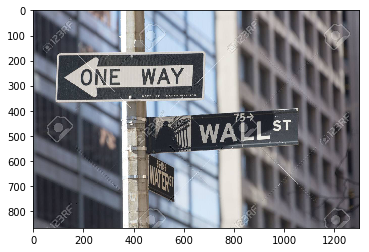

(1, 2048)
Rank: 1 STREET
Rank: 2 SIGN
Rank: 3 BEAR
Rank: 4 CITY
Rank: 5 LIGHT
Rank: 6 STOP
Rank: 7 ROAD
Rank: 8 TRUCK
Rank: 9 TEDDY
Rank: 10 BUILD
Rank: 11 TRAFFIC
Rank: 12 HYDRANT
Rank: 13 CARS
Rank: 14 STUFF
Rank: 15 DRIVE
Rank: 16 POLE
Rank: 17 WHITE
Rank: 18 INTERSECTION
Rank: 19 LARGE
Rank: 20 NIGHT
Rank: 21 SIDEWALK
Rank: 22 NEAR
Rank: 23 CORNER
Rank: 24 GREEN
Rank: 25 BUSY
Rank: 26 WALK
Rank: 27 PARK
Rank: 28 CROSS
Rank: 29 PICTURE
Rank: 30 BACKGROUND
Rank: 31 BLUE
Rank: 32 VIEW
Rank: 33 POST
Rank: 34 TALL
Rank: 35 TREE
Rank: 36 ANIMALS
Rank: 37 SMALL
Rank: 38 YELLOW
Rank: 39 STAND
Rank: 40 GRAFFITI
Rank: 41 CURB
Rank: 42 CLOSE
Rank: 43 OUTSIDE
Rank: 44 ATTACH
Rank: 45 TENNIS
Rank: 46 COURT
Rank: 47 BALL
Rank: 48 RACKET
Rank: 49 PLAYER
Rank: 50 PLAY
Rank: 51 HOLD
Rank: 52 WOMAN
Rank: 53 RACQUET
Rank: 54 SWING
Rank: 55 SERVE
Rank: 56 MATCH
Rank: 57 SHIRT
Rank: 58 YOUNG
Rank: 59 MALE
Rank: 60 READY
Rank: 61 PREPARE
Rank: 62 HAND
Rank: 63 GAME
Rank: 64 TOILET
Rank: 65 BATHROOM
Rank

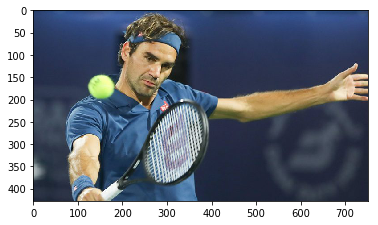

(1, 2048)
Rank: 1 TENNIS
Rank: 2 BALL
Rank: 3 COURT
Rank: 4 PLAYER
Rank: 5 RACKET
Rank: 6 PLAY
Rank: 7 HOLD
Rank: 8 WOMAN
Rank: 9 RACQUET
Rank: 10 SWING
Rank: 11 PEOPLE
Rank: 12 SERVE
Rank: 13 STAND
Rank: 14 GAME
Rank: 15 MATCH
Rank: 16 YOUNG
Rank: 17 SHIRT
Rank: 18 MALE
Rank: 19 GROUP
Rank: 20 READY
Rank: 21 WHITE
Rank: 22 PREPARE
Rank: 23 HAND
Rank: 24 SHORT
Rank: 25 PARK
Rank: 26 PERSON
Rank: 27 BLUE
Rank: 28 BLACK
Rank: 29 WEAR
Rank: 30 PLAYERS
Rank: 31 FEMALE
Rank: 32 RETURN
Rank: 33 BASEBALL
Rank: 34 LOOK
Rank: 35 MOTORCYCLE
Rank: 36 WOMEN
Rank: 37 WALK
Rank: 38 BEACH
Rank: 39 SOCCER
Rank: 40 FIELD
Rank: 41 OUTSIDE
Rank: 42 COUPLE
Rank: 43 CROWD
Rank: 44 VIDEO
Rank: 45 CHILDREN
Rank: 46 POSE
Rank: 47 BIKE
Rank: 48 UMBRELLAS
Rank: 49 ROAD
Rank: 50 PICTURE
Rank: 51 WATCH
Rank: 52 LARGE
Rank: 53 GATHER
Rank: 54 BUILD
Rank: 55 DOUBLE
Rank: 56 STREET
Rank: 57 TALK
Rank: 58 BICYCLE
Rank: 59 NEAR
Rank: 60 DRESS
Rank: 61 SIDEWALK
Rank: 62 DECKER
Rank: 63 BOYS
Rank: 64 BATTER
Rank: 65 PHO

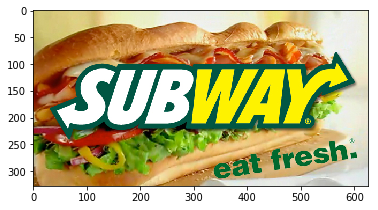

(1, 2048)
Rank: 1 PLATE
Rank: 2 PARK
Rank: 3 FOOD
Rank: 4 MOTORCYCLE
Rank: 5 CAKE
Rank: 6 TABLE
Rank: 7 SANDWICH
Rank: 8 PLAY
Rank: 9 WHITE
Rank: 10 GAME
Rank: 11 PIECE
Rank: 12 SLICE
Rank: 13 BROCCOLI
Rank: 14 VIDEO
Rank: 15 PEOPLE
Rank: 16 MEAT
Rank: 17 HOLD
Rank: 18 VEGETABLES
Rank: 19 PIZZA
Rank: 20 FORK
Rank: 21 ROAD
Rank: 22 STAND
Rank: 23 PERSON
Rank: 24 PLAT
Rank: 25 SALAD
Rank: 26 DOUBLE
Rank: 27 OUTSIDE
Rank: 28 TRAY
Rank: 29 STREET
Rank: 30 BREAD
Rank: 31 CHEESE
Rank: 32 BUILD
Rank: 33 SMALL
Rank: 34 DISH
Rank: 35 NEAR
Rank: 36 DECKER
Rank: 37 SERVE
Rank: 38 CANDLE
Rank: 39 BOWL
Rank: 40 CONTROLLER
Rank: 41 HALF
Rank: 42 CARS
Rank: 43 SNOW
Rank: 44 SAUCE
Rank: 45 CLOSE
Rank: 46 CHOCOLATE
Rank: 47 COFFEE
Rank: 48 BIRTHDAY
Rank: 49 KNIFE
Rank: 50 MOTOR
Rank: 51 NINTENDO
Rank: 52 LINE
Rank: 53 WOMAN
Rank: 54 GREEN
Rank: 55 SKATEBOARD
Rank: 56 REMOTE
Rank: 57 BIKE
Rank: 58 DRIVE
Rank: 59 CONTROLLERS
Rank: 60 CITY
Rank: 61 GROUP
Rank: 62 AREA
Rank: 63 UMBRELLA
Rank: 64 MARKET
Ran

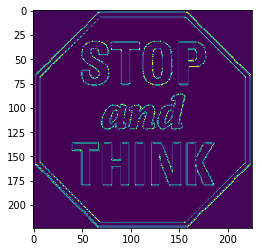

(1, 2048)
Rank: 1 BASEBALL
Rank: 2 SIGN
Rank: 3 TRUCK
Rank: 4 PLAYER
Rank: 5 STREET
Rank: 6 STOP
Rank: 7 GAME
Rank: 8 HYDRANT
Rank: 9 BALL
Rank: 10 FIELD
Rank: 11 ROAD
Rank: 12 SWING
Rank: 13 STAND
Rank: 14 PLAYERS
Rank: 15 PLAY
Rank: 16 BATTER
Rank: 17 WHITE
Rank: 18 BEAR
Rank: 19 BUILD
Rank: 20 BASE
Rank: 21 PITCH
Rank: 22 PARK
Rank: 23 SIDEWALK
Rank: 24 UNIFORM
Rank: 25 POLE
Rank: 26 CATCHER
Rank: 27 PLATE
Rank: 28 READY
Rank: 29 LARGE
Rank: 30 GROUP
Rank: 31 GREEN
Rank: 32 POLAR
Rank: 33 BLUE
Rank: 34 HOME
Rank: 35 HOLD
Rank: 36 CITY
Rank: 37 NEAR
Rank: 38 TREE
Rank: 39 POST
Rank: 40 TEAM
Rank: 41 PITCHER
Rank: 42 THROW
Rank: 43 SMALL
Rank: 44 BLACK
Rank: 45 ROCK
Rank: 46 WATER
Rank: 47 YELLOW
Rank: 48 UMPIRE
Rank: 49 WALK
Rank: 50 CORNER
Rank: 51 GRAFFITI
Rank: 52 BIRD
Rank: 53 CURB
Rank: 54 CLOSE
Rank: 55 GIRL
Rank: 56 OUTSIDE
Rank: 57 ATTACH
Rank: 58 BACKGROUND
Rank: 59 DRIVE
Rank: 60 WOMAN
Rank: 61 TENNIS
Rank: 62 LITTLE
Rank: 63 YOUNG
Rank: 64 BRANCH
Rank: 65 LOOK
Rank: 66 TAK

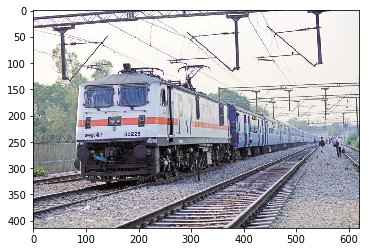

(1, 2048)
Rank: 1 TRAIN
Rank: 2 TRACK
Rank: 3 STATION
Rank: 4 TRAVEL
Rank: 5 YELLOW
Rank: 6 BRIDGE
Rank: 7 PASSENGER
Rank: 8 PULL
Rank: 9 PLATFORM
Rank: 10 BLUE
Rank: 11 NEAR
Rank: 12 LONG
Rank: 13 RAIL
Rank: 14 PASS
Rank: 15 WHITE
Rank: 16 ENGINE
Rank: 17 WAIT
Rank: 18 STOP
Rank: 19 PARK
Rank: 20 COME
Rank: 21 RAILROAD
Rank: 22 CARS
Rank: 23 PASSENGERS
Rank: 24 LARGE
Rank: 25 BLACK
Rank: 26 TREE
Rank: 27 ORANGE
Rank: 28 MOVE
Rank: 29 COMMUTER
Rank: 30 PEOPLE
Rank: 31 FIELD
Rank: 32 GRASS
Rank: 33 STAND
Rank: 34 SHEEP
Rank: 35 FENCE
Rank: 36 GRASSY
Rank: 37 GRAZE
Rank: 38 GREEN
Rank: 39 HERD
Rank: 40 GROUP
Rank: 41 AREA
Rank: 42 WALK
Rank: 43 LOOK
Rank: 44 ANIMALS
Rank: 45 LUSH
Rank: 46 PASTURE
Rank: 47 OPEN
Rank: 48 BROWN
Rank: 49 TALL
Rank: 50 LAPTOP
Rank: 51 WIRE
Rank: 52 SMALL
Rank: 53 YARD
Rank: 54 HILL
Rank: 55 COVER
Rank: 56 GOATS
Rank: 57 WINDOW
Rank: 58 SIGN
Rank: 59 DESK
Rank: 60 TABLE
Rank: 61 TRUCK
Rank: 62 STREET
Rank: 63 MOUSE
Rank: 64 HYDRANT
Rank: 65 SCREEN
Rank: 66 KEY

In [38]:
#model = load(open("models/model_30_topics_7:53pm_val_2017",'rb'))
test_images("test_img",30)

In [ ]:
len(probabs)

In [ ]:
for index,tup in enumerate(probabs):
    if tup[0] == 'kite':
        print(index)

In [ ]:
s = 0
for x in probabs:
    s += x[1]
s